In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize, Bounds
import matplotlib.pyplot as plt
from datetime import date
from tqdm.notebook import tqdm_notebook
import math
import time

In [2]:
def get_data(assets, start_date, end_date, time_interval):
    return yf.download(assets, 
                          start = start_date, 
                          end = end_date,
                          interval = time_interval,
                          threads = True,
                          progress = False)['Adj Close']

In [3]:
assets  = [ 'SPY', "QQQ", "VGK", "SCZ", "EWJ", "EEM", #eq
           'REM', "VNQ", "RWX", # re
           'TIP', "IEF", "TLT", "BWX", #fi
           'DBC', "GLD", #como
           'twtr', 'intc', 'tsm',"VWUSX", "Amc"]


# ----------- DATES ------
start_train_date = '2020-01-01'
end_train_date = '2021-01-01'
start_test_date = end_train_date
end_test_date = date.today()
interval = "1d"


all_stocks = get_data(assets, '2014-01-01', '2020-01-01', "1d")

"""returns = np.log(all_stocks/all_stocks.shift(1))
returns.fillna(0)
returns_raw = returns.iloc[1: , :]

int((returns_raw.shape[0]-253)/20)"""

'returns = np.log(all_stocks/all_stocks.shift(1))\nreturns.fillna(0)\nreturns_raw = returns.iloc[1: , :]\n\nint((returns_raw.shape[0]-253)/20)'

Initialisation des variables

In [47]:
def init(Money, periode_trades):
    
    global memo, X, cash, argent_gagne, couts_transaction, s, argent_fait, pf_value, pos, pos2, bounds, nb_actifs, returns_raw
    
    # Variables utilisées dans l'algorithme

    returns = np.log(all_stocks/all_stocks.shift(periode_trades))
    returns.fillna(0)
    returns_raw = returns.iloc[periode_trades: , :]
    
    cash = Money
    win = 0
    argent_gagne = 0
    cout = 0
    couts_transaction = 0
    s = 0
    nb_actifs = returns_raw.shape[1]
    argent_fait = [Money]
    pf_value = 0
    X = []
    memo = {}

    # pos = portefeuille initialement vide
    pos = np.array([0 for i in range(nb_actifs)])


Fonctions objectif et coûts de transaction

In [91]:
def objective_cov(pos, returns, covar_matrix, alpha, memoisation, pospre,vp):
    global s
    if memoisation:
        x = str(pos)
        if x not in memo:
            s = pos@covar_matrix@pos - alpha*returns@pos +TC(pospre,pos,vp)
            memo[x] = s
        else:
            s = memo[x]
            # print("la mémo a été utile")
    else:
        s = pos@covar_matrix@pos - alpha*returns@pos +TC(pospre,pos,vp)
    
    # print(f"Valeur de la fonction objectif : {s.round(3)}")
    return s

def TC(pos,pos2, vp):
    return lamb*(np.sum(np.array([np.abs((pos2[i]-pos[i])*vp[i]) for i in range(nb_actifs)])))


Import des données roulantes à l'étape i

In [100]:
def import_donnees(etape):
    global X
    
    # import des données roulantes, on calcule à partir des données de l'année précédente
    log_returns = returns_raw.iloc[etape:253+etape, :]
    # calcul des expected returns (par Standard Moving Average, et on prend une période plus courte)
    expected_returns_SMA = log_returns.iloc[-jours_returns:: ,:].mean()
    # calcul des expected returns (par Exponential Moving Average)
    expected_returns_EMA = log_returns.iloc[-jours_returns*3:: ,:].ewm(span=jours_returns, adjust=False).mean().iloc[-1,:]
    
    # calcul de la matrice de covariance
    covar = log_returns.cov().copy()
    covar_matrix = covar.to_numpy()
    
    correl = log_returns.corr().copy()
    correl_matrix = correl.to_numpy()

    # calcul du vecteur prix des actifs à t (le temps de la décision) et t + 1jour
    vp = all_stocks[253+etape::].values[0]
    vp2 = all_stocks[253+etape+periode_trades::].values[0]
    
    expected_returns = np.array([expected_returns_EMA[i]*vp[i] for i in range(nb_actifs)])

    #X.append(str(returns_raw.iloc[253+etape].name).split()[0])
    #print(str(log_returns.iloc[-1].name).split()[0])
    memo = {}
    
    return expected_returns, covar_matrix, vp, vp2, memo

Fonctions contraintes

In [151]:
#def cons1(x,Money,vp):
    # on ne peut pas investir plus que ce qu'on possède
    #return Money - np.sum([x[i]*vp[i] for i in range(nb_actifs)])

def cons2(x,cash,pos,vp):
    # pour payer les coûts de transaction, il faut soit utiliser du cash soit vendre des positions (pour un prix -delta_P*vp)
    return cash + np.sum([(pos[i]-x[i])*vp[i] for i in range(nb_actifs)]) - TC(pos,x,vp)

def cons3(x,returns,vp, gain_cible):
    # on veut au moins que le gain soit supérieur à gain_cible
    return np.sum([returns[i]*vp[i]*x[i] for i in range(nb_actifs)]) - gain_cible
def cons4(x,pos,dPmax):
    return dPmax-max([abs(x[i]-pos[i]) for i in range (nb_actifs)])

Calcul de l'optimisation roulante

In [152]:
def compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades, nb_etapes, gain_cible, debug=True):
    
    global pf_value, pos, pos2, argent_gagne, cout, win, cash, couts_transaction, pospre
    global Test_pos, Test_TC, Test_money, Test_cash, TCs, Moneys, Cashs
    
    init(Money, periode_trades)
    Test_pos = [[0 for i in range(nb_actifs)]]
    Test_TC = [0]
    Test_money = [0]
    Test_cash = [0]
    TCs = [0]
    Moneys = [0]
    Cashs = [0]
    if debug:
        print("Argent injecté au départ:", Money)


    for i in tqdm_notebook(range(min(nb_etapes,int((returns_raw.shape[0]-253)/periode_trades)))):

        # calcul des returns, de la matrice de variance, des vecteurs prix
        returns, covar_matrix, vp, vp2, memo = import_donnees(i*periode_trades)

        cons = (#{"type":"ineq", "fun": lambda x: cons1(x,Money,vp)}, --> contrainte finalement inutile vis à vis de la seconde
               {"type": "ineq", "fun": lambda x: cons2(x,cash,pos,vp)},
               {"type": "ineq", "fun": lambda x: cons3(x,returns,vp, gain_cible)},
            {"type": "ineq", "fun": lambda x: cons4(x,pos,dPmax)}
            
               )
        
        bounds = Bounds(-Pos_max_par_actif, Pos_max_par_actif)
        
        # calcul du vecteur position
        p = minimize(objective_cov, pos, 
                 method = "SLSQP",
                 bounds = bounds,
                 constraints = cons,
                args=(returns, covar_matrix, alpha, memoisation, pos,vp),
                options={'maxiter': 300, 'ftol':1e-10})
        if not p.success:
            print("False")
            #newpos=pos
        newpos=p.x
            
        cout = TC(pos,newpos, vp)
        
        TCs.append(cout)
        test_cout = TC(Test_pos[-1],[fact*newpos[i] for i in range(len(newpos))],vp)
        Test_TC.append(test_cout)
        """
        print(cons1(p.x,Money,vp))
        print(cons2(p.x,cash,pos,vp))
        print("gain espéré",cons3(p.x,returns,vp,gain_cible)+gain_cible)"""
        
        couts_transaction += cout

        pos = newpos # les positions prises en fin de journée
        Test_pos.append([fact*pos[i] for i in range(len(pos))])
        
        pf2_value = np.sum([pos[i]*vp[i] for i in range(nb_actifs)])


        cash_restant = Money - (pf2_value + cout) # = valeur totale à t-1 - argent ivesti à t
        cash = cash_restant # l'argent que l'algo décide de ne pas investir
        
        test_cash = Test_money[-1] - np.sum([Test_pos[-1][i]*vp[i] for i in range(nb_actifs)]) - test_cout
        Test_cash.append(test_cash)
        Cashs.append(cash)

        if debug:
            print("\n","Etape {}:".format(i))

            # affichage des valeurs numériques
            print('\033[94m'+"Somme des positions: "+str(pf2_value)+'\033[0m')
            print('\033[92m'+"Coûts de transaction: "+str(cout)+'\033[0m')
            print("cash :", cash.round(6))
            print(f"La valeur de la fonction objectif:{s}")

        # mise à jour à chaque actualisation des prix
        pf_value = np.sum([pos[i]*vp2[i] for i in range(nb_actifs)])
        Money = pf_value + cash
        Test_money.append(np.sum([Test_pos[-1][i]*vp2[i] for i in range(nb_actifs)]) + test_cash)
        argent_fait.append(Money)
        win = pf_value - pf2_value
        argent_gagne += win
        if debug:
            print('\033[94m'+"Somme des positions: "+str(pf_value)+'\033[0m')
            print('\033[95m'+"Argent généré sans TC : "+str(win)+'\033[0m')
            print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")

        
        """print('\033[95m'+"Gain réel sans TC : "+str(win)+'\033[0m')
        print('\033[92m'+"Coûts de transaction: "+str(cout)+'\033[0m')
        print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")"""
        
    if debug:
        print("\n","fin du calcul")

    print('\033[95m'+"Argent total généré sans TC : "+str(argent_gagne)+'\033[0m')
    print('\033[92m'+"Coûts totaux de transaction: "+str(couts_transaction)+'\033[0m')
    print('\033[96m'+"Money :"+str(Money)+'\033[0m', "\n")


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False

Argent total généré sans TC : 10319.211787535492
Coûts totaux de transaction: 3594.3809069733547
Money :6724.83088056213 

Temps d'exécution: 211.41964173316956


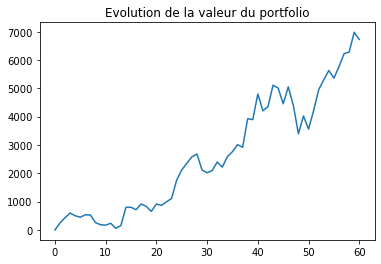

In [177]:
# Paramètres modifiables

lamb = 0.01 # Coûts de transaction ; faire attention car sinon il n'y a pas de mouvements de position
alpha = 1 # importance accordée à l'expected return
Money = 0 # argent alloué pour l'investissement initial
Pos_max_par_actif = 10000 # quantité maximale d'argent investi par actif
jours_returns = 10 # les n derniers jours qui servent pour calculer les expected returns
periode_trades = 20 # le nombre de jours ouvrés qui séparent chaque décision
memoisation = True
dPmax = 10
gain_cible = 0.015
fact=10000

start = time.time()
compute_portfolio(lamb, alpha, Money, Pos_max_par_actif, jours_returns, periode_trades,60, gain_cible, False)
end = time.time()
print('\033[90m'+"Temps d'exécution: "+format(end-start)+'\033[0m')


plt.plot(argent_fait)
plt.title("Evolution de la valeur du portfolio")
plt.show()

In [175]:
print("Pente moyenne :", int(10000*argent_fait[-1]/(25))/10000,"par période")
L=[]
print(argent_fait)
for i in range(2,25):
    L.append((argent_fait[i]-argent_fait[i-1])/argent_fait[i-1])
test = np.array(L)
print(np.mean(test))
print(L)

Pente moyenne : -337.362 par période
[0, -0.004016742926423715, -0.010689992396745906, -0.010514637980269604, -0.03296208836987825, -30.816747171025543, -30.159305211413027, -29.767120646100356, -27.533276515057995, -925.8298717664337, -1351.3667005419122, -1420.6677507559982, -1397.9291854483836, -1309.9157816190782, -1271.5988726845471, -4191.8794238814025, -4241.167622736338, -4385.391289316574, -4438.663149098163, -4465.4105079389665, -4492.348595241267, -4852.086334669726, -5118.830117761392, -5356.428531952706, -5517.964001494416, -5555.438557544556, -5538.74962550801, -5468.065679138099, -5489.7962681659155, -5478.82344100281, -5453.029588938646, -5451.47077977963, -5419.524318500411, -5316.190933554841, -5374.560066065929, -5389.841407237194, -5360.8764658410955, -5421.48509415904, -5412.396555575136, -5439.660089317739, -5458.797174033732, -7270.075526083507, -7316.824301832645, -7397.4255943453045, -7438.557720663324, -7394.322578232349, -7536.110051564036, -7524.854704163862

Test

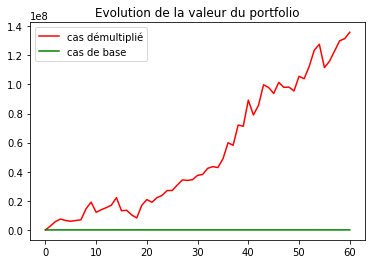

In [170]:
plt.plot(Test_money,'r', label="cas démultiplié")
plt.plot(argent_fait,'g', label="cas de base")
plt.legend()
plt.title("Evolution de la valeur du portfolio")
plt.show()

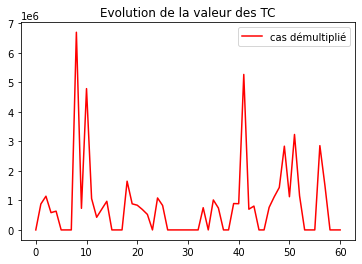

In [171]:
plt.plot(Test_TC,'r', label="cas démultiplié")
#plt.plot([TCs[i] for i in range(len(TCs))],'g', label="cas de base")
plt.legend()
plt.title("Evolution de la valeur des TC")
plt.show()

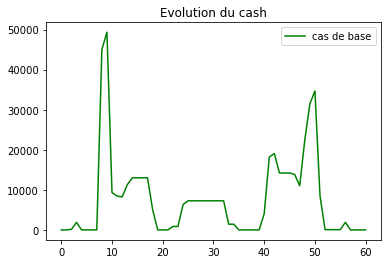

In [172]:
#plt.plot(Test_cash,'r', label="cas démultiplié")
plt.plot([Cashs[i] for i in range(len(Cashs))],'g', label="cas de base")
plt.legend()
plt.title("Evolution du cash")
plt.show()

Calcul du drawdown

In [173]:
drawdown = -math.inf
maxi = -math.inf
mini = math.inf
i = 0
details = False # afficher plus de détails

for x in argent_fait:
    if x > maxi:
        if details :
            print("max atteint en{}:{}".format(i, argent_fait[i]) )
        maxi = x
        mini = math.inf
    elif x < mini:
        if details:
            print("min atteint en{}:{}".format(i, argent_fait[i]) )
        mini = x
        if maxi != 0:
            drawdown = max(drawdown, (maxi-mini)/maxi)
    i+=1

drawdown

0.43347429357980916

In [165]:
pos.round(3)

array([ -29.764,  -62.054,  -32.592,  -40.113,  -15.196,   33.394,
         15.404,   48.495,   23.292,  -43.575,  -67.74 ,  100.98 ,
         21.778, -145.83 ,    7.401,   13.034,   22.928,  -61.923,
         78.098,   19.52 ])

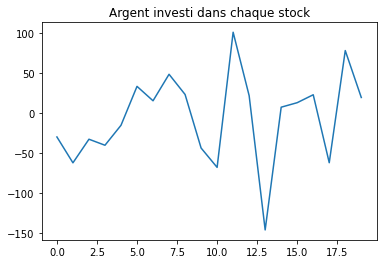

L'argent est le plus investi dans l'action: TLT


In [166]:
plt.plot([pos[i] for i in range(len(pos))])
plt.title("Argent investi dans chaque stock")
plt.show()
print("L'argent est le plus investi dans l'action: "+assets[np.argmax(pos)])

In [148]:
print("Nombre d'action acheté pour chaque symbols: ")
r = pd.DataFrame([assets,pos])
for i in range(len(assets)):
    print(assets[i],pos[i].round(3))

Nombre d'action acheté pour chaque symbols: 
SPY -42.694
QQQ 11048.831
VGK 55933.231
SCZ 15320.967
EWJ 1415.893
EEM 13283.342
REM -65288.404
VNQ -2894.909
RWX 26961.075
TIP 10274.28
IEF 1257.265
TLT 52633.034
BWX -31250.085
DBC -66079.485
GLD 47232.264
twtr 2473.784
intc -3111.764
tsm -36655.931
VWUSX 19739.853
Amc -82187.555
